In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../")
from get_payload_data import read_adc_file

%matplotlib widget


# Notebook to have a quick look on ADC data

## Plot raw data

In [2]:
adc_path = "/home/tsouverin/polocalc/data_loader/quick_look/20250416_115757/sensors_data/ADS1015_20250416_115757.bin"
adc_data = read_adc_file(adc_path)

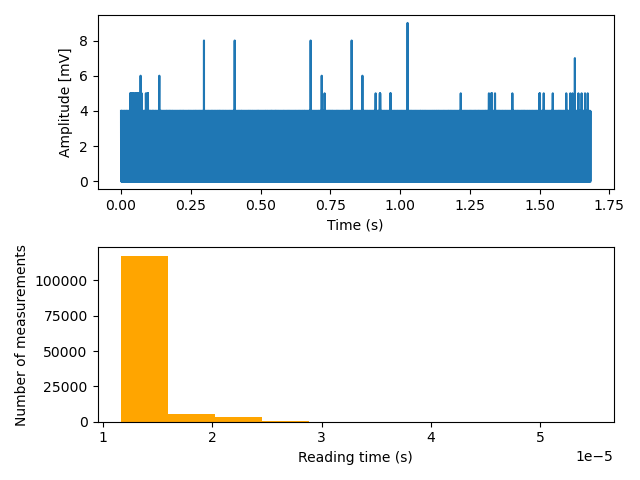

In [3]:
fix, axs = plt.subplots(2, 1)
axs[0].plot(adc_data["timestamp"], adc_data["amplitude"])
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude [mV]")

axs[1].hist(adc_data["timestamp"].diff(), color="orange")
axs[1].set_xlabel("Reading time (s)")
axs[1].set_ylabel("Number of measurements")

plt.tight_layout()
plt.show()

## Compute into dBm

In [4]:
HP_diode = {'Frequency [GHz]': 93,
            'Responsivity [mV/mW]': -58.55,
            'Error [mV/mW]': 0.22
           }
Eravant_diode = {'Frequency [GHz]': np.array([84,87,90,93,96,99,102]),
                 'Responsivity [mV/mW]': np.array([106.29,128.73,136.59,133.19,152.43,161.78,81.64]),
                 'Error [mV/mW]': np.array([2.58,4.47,5.27,5.19,8.93,10.00,8.03])
                }
Transmission_factor = {"84 GHz": -0.83,
                       "87 GHz": -0.79,
                       "90 GHz": -0.73,
                       "93 GHz": -0.68,
                       "96 GHz": -0.64,
                       "99 GHz": -0.61,
                       "102 GHz": -0.62
                      }
Coupling_factor = {"84 GHz": -20.36,
                   "87 GHz": -20.26,
                   "90 GHz": -20.13,
                   "93 GHz": -20.10,
                   "96 GHz": -20.14,
                   "99 GHz": -20.25,
                   "102 GHz": -20.49
                  }
Attenuator_factor = {"84 GHz": -28.18,
                     "87 GHz": -29.29,
                     "90 GHz": -29.69,
                     "93 GHz": -29.98,
                     "96 GHz": -30.97,
                     "99 GHz": -31.24,
                     "102 GHz": -31.25
                    }
Gain_factor = {"84 GHz": 7.11,
               "87 GHz": 7.59,
               "90 GHz": 7.74,
               "93 GHz": 7.60,
               "96 GHz": 7.82,
               "99 GHz": 8.07,
               "102 GHz": 8.26
              }

In [5]:
def mW_to_dBm(pwr_mW):
    return 10*np.log10(pwr_mW)
def dBm_to_mW(pwr_dBm):
    return 10**(pwr_dBm/10)

def get_out_pwr_coupl(diode_response, responsivity, transm, coupling):
     return mW_to_dBm(diode_response/responsivity * 10**((transm-coupling)/10))

def get_output_pwr(diode_response, responsivity, transm, coupling, atten, gain):
    return get_out_pwr_coupl(diode_response, responsivity, transm, coupling) + atten + gain

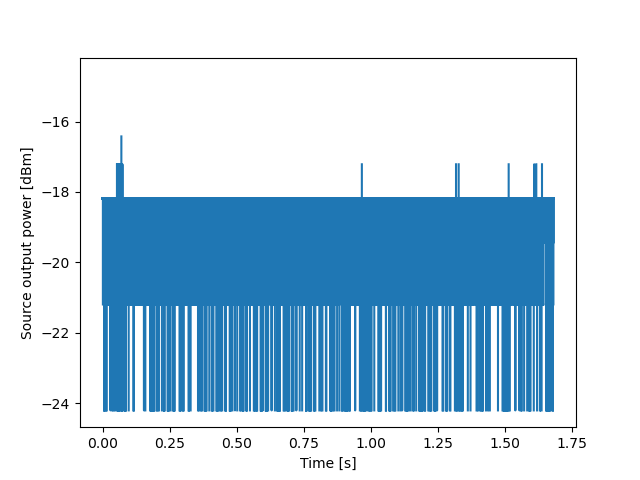

In [7]:
output_pwr = get_output_pwr(adc_data["amplitude"],Eravant_diode['Responsivity [mV/mW]'][(Eravant_diode["Frequency [GHz]"] == 93)],
                            Transmission_factor['93 GHz'],
                            Coupling_factor['93 GHz'],
                            Attenuator_factor['93 GHz'],
                            Gain_factor['93 GHz'])
abs_time = adc_data["timestamp"]

plt.figure()
plt.plot(abs_time, output_pwr)
plt.ylabel("Source output power [dBm]")
plt.xlabel("Time [s]")
plt.show()

## Compute expected power seen by the detectors

In [8]:
import astropy.units as u
import astropy.constants as const

In [9]:
def get_beam_solid_angle(fwhm):
    """
    fwhm: should be in radians
    """
    return 2 *  np.pi * (fwhm*u.rad  / np.sqrt(8*np.log(2)))**2
def get_detector_gain(beam_solid_angle):
    """
    Return the gain of a single detector in dBi
    (assume u.dB is dBi here since we multiply with 4pi)
    """
    fw_gain = 10*np.log10(4*np.pi / beam_solid_angle.value)
    return (fw_gain) * u.dB
def get_detector_power(output_power, detector_gain, freq, optical_efficiency, distance=500, duty_cycle=0.5):
    """
    Include the distance and the optical efficiency
    and return receiver power in dBm
    freq: assumed in GHz
    """
    fspl = (const.c.value / (4 * np.pi * freq * u.GHz.to(u.Hz) * (distance*u.meter).value))**2
    fspl_dBm = 10*np.log10(fspl)
    fspl_dBm *= u.dB
    optical_efficiency_loss = (10*np.log10(optical_efficiency * duty_cycle))*u.dB
    return detector_gain + output_power + fspl_dBm + optical_efficiency_loss
def get_drone_power(effective_diameter, beam_solid_angle, optical_efficiency, temp=300, distance=500, bandpass=30):
    """
    temp: assumed commonly a perfect blackbody of 300 K
    effective_diameter: for POLOCALC/hovercal is 0.5 m
    bandpass: assumed in GHz
    """
    effective_angular_diameter = effective_diameter*u.meter / distance*u.meter
    dilution_factor = np.pi * (effective_angular_diameter.value / 2) ** 2 / beam_solid_angle.value
    return (10*np.log10(const.k_B.to(u.mJ/u.K).value * (temp*u.K).value * (bandpass*u.GHz.to(u.Hz) * optical_efficiency * dilution_factor)))*u.dB

In [10]:
fwhms = {'f090':27.4, 'f150':21} #in arcmins
freqs = {'f090':90, 'f150':150}
pre_c_omegas = {'f090':136*1e-06, 'f150':51*1e-06}

In [11]:
telescope_name = 'SO_SATs'
source_name = 'polocalc'
band = 'f090'
full_name = source_name+'_'+telescope_name+'_'+band

In [12]:
if telescope_name=='SO_SATs':
    # Get beam solid angle
    omega_rad = np.radians(fwhms[band]/60)
    omega = get_beam_solid_angle(omega_rad)
else:
    omega = pre_c_omegas[full_name]

In [13]:
# Get detector gain in dB --> dBm --> dBi
detector_gain = get_detector_gain(omega)
detector_gain

<Quantity 52.41992084 dB>

In [ ]:
avg_out_pwr = output_pwr[~output_pwr.eq(0)].mean()
output_power = -18.2#avg_out_pwr*u.dB

-inf


In [17]:
output_power = avg_out_pwr*u.dB

dets_power = []
#for opt_eff in [.232-.013, .232, .232+.013]:
for opt_eff in [.308-.016, .308, .308+.016]:
    drone_power = get_drone_power(temp=300, distance=500, effective_diameter=0.5, beam_solid_angle=omega, optical_efficiency=opt_eff, bandpass=30)
    det_power = get_detector_power(output_power, detector_gain, freq=freqs[band], optical_efficiency=opt_eff)
    dets_power.append(10**((det_power.value-30)/10)*1e12 + 10**((drone_power.value-30)/10)*1e12)
    # dets_power.append(10**((drone_power.value-30)/10)*1e12)
print(np.array(dets_power).T)

[0.39589566 0.41758858 0.43928149]
